# Based on a dataset with customers profiles, calculate the optimal strategy for health insurance pricing according to a linear regression model

## Import Libraries

In [1]:
# Import necessary libraries.
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from pylab import *


# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To enable plotting graphs in Jupyter notebook
%matplotlib inline


<font color=darkblue>
    
## Loading and exploring the data


In [2]:
data = pd.read_excel("health.xlsx")

In [3]:
data.shape #The File has 365 Rows with Data AND 3 Columns

(1338, 7)

In [4]:
len(data) # confirm the number of rows

1338

In [5]:
data.columns #The Columns names are described below. Names are very long but will remain for this exercise.

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [6]:
data.dtypes.value_counts() # Data are all numerical

object     3
float64    2
int64      2
dtype: int64

In [7]:
data.info()
# Check the characteristics of the data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
data.head(10) #Visually check the first 10 Rows

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [9]:
data.isnull().sum() 
#no missing values

age         0
gender      0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
data.region.value_counts() #distribution of the events into the four different regions

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [11]:
data.gender.value_counts() #distribution of events in the gender category

male      676
female    662
Name: gender, dtype: int64

In [12]:
data.smoker.value_counts() # distribution of events in smoker category is very unbalanced

no     1064
yes     274
Name: smoker, dtype: int64

In [13]:
data.describe() 
#These are the statistical values for numerical columns. 
# We can see the mean,standard deviation, minimum, maximum as well as first, second and third quantiles.

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [14]:
df = data.copy()

In [15]:
# drop duplicate rows
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: {}".format(duplicate_rows_df.shape))
df = df.drop_duplicates()

number of duplicate rows: (1, 7)


In [16]:
df.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [17]:
# replace region id with numerical values
df['regionid'] = df['region']
df['regionid'].replace(to_replace ='southwest', value = 1, inplace=True)
df['regionid'].replace(to_replace ='southeast', value = 2, inplace=True)
df['regionid'].replace(to_replace ='northwest', value = 3, inplace=True)
df['regionid'].replace(to_replace ='northeast', value = 4, inplace=True)

In [18]:
# replace gender with numerical values
df['genderid'] = df['gender']
df['genderid'].replace(to_replace ='male', value = 1, inplace=True)
df['genderid'].replace(to_replace ='female', value = 2,inplace=True)

In [19]:
# replace smoker category with numerical values
df['smokerid'] = df['smoker']
df['smokerid'].replace(to_replace ='yes', value = 1, inplace=True)
df['smokerid'].replace(to_replace ='no', value = 0,inplace=True)

In [20]:
df.info() # check for missing values and data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   gender    1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
 7   regionid  1337 non-null   int64  
 8   genderid  1337 non-null   int64  
 9   smokerid  1337 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 114.9+ KB


In [21]:
df.describe() 

,age,bmi,children,charges,regionid,genderid,smokerid
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487,2.483919,1.495138,0.204936
std,14.044333,6.100468,1.205571,12110.359656,1.105208,0.500163,0.403806
min,18.000000,15.960000,0.000000,1121.873900,1.000000,1.000000,0.000000
25%,27.000000,26.290000,0.000000,4746.344000,2.000000,1.000000,0.000000
50%,39.000000,30.400000,1.000000,9386.161300,2.000000,1.000000,0.000000
75%,51.000000,34.700000,2.000000,16657.717450,3.000000,2.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,4.000000,2.000000,1.000000


### Correlation Matrix

The Matrix shows how much two variables works towards the same goal, a positive correlation shows if one increases the other will increase too. 
Negative correlation would be the opposite, if one variable increases, the other will decrease.
The values/numerical number show the proportion of this relation, if the correlation is one, the variables are perfect correlated, an increase of one point in one variable will result in the same increase for the second variable.
Correlation above 0.5 or below -0.5 are statistically relevant, otherwise they do not have a high effect. 

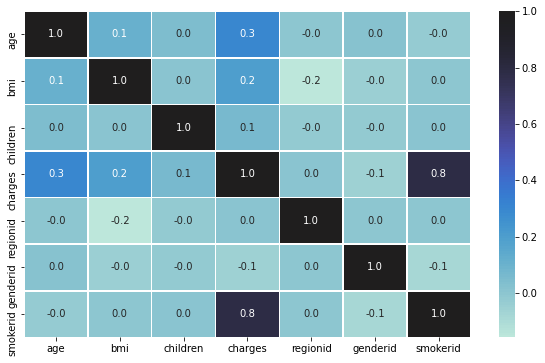

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f', center = 1 )  # heatmap
plt.show()

## EDA Analysis

In [23]:

def histogram_boxplot(feature, figsize=(10, 8), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    sns.set(font_scale=2)  # setting the font scale for seaborn
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid=2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="red"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        feature.mean(), color="g", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        feature.median(), color="black", linestyle="-"
    )  # Add median to the histogram

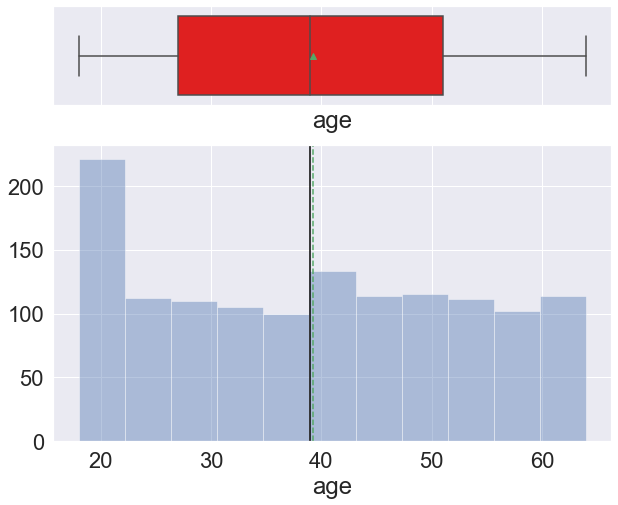

In [24]:
histogram_boxplot(df.age)

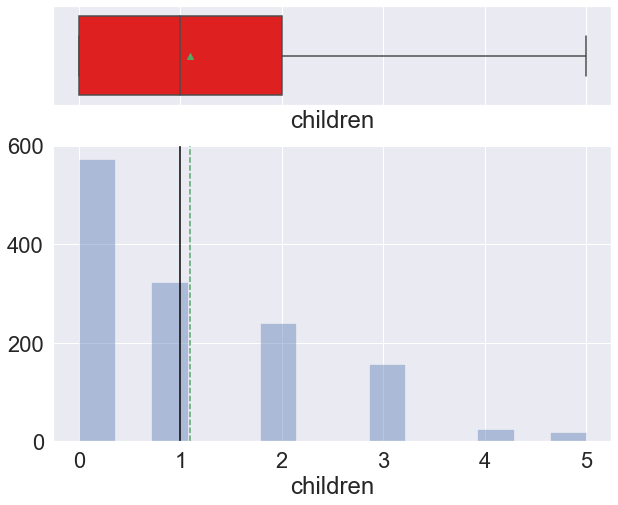

In [25]:
histogram_boxplot(df.children)

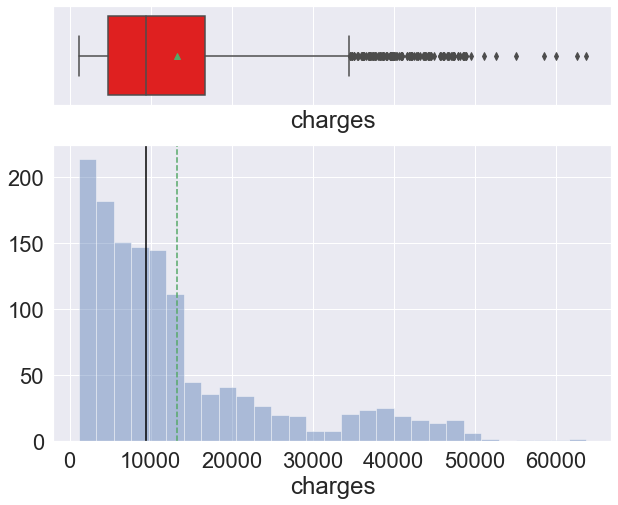

In [26]:
histogram_boxplot(df.charges)

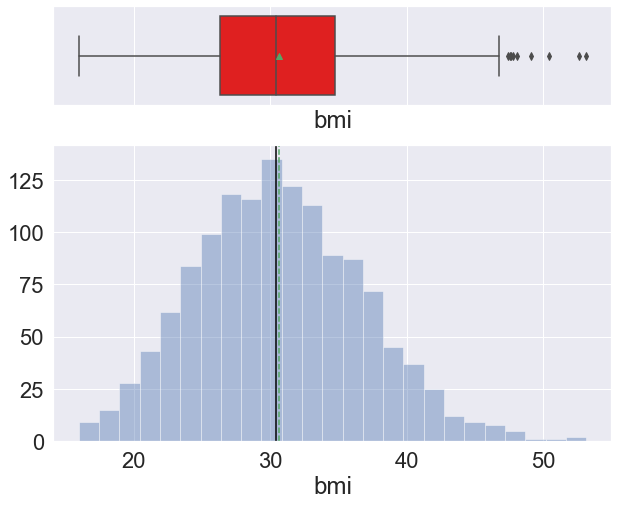

In [27]:
histogram_boxplot(df.bmi)

### Scatterplot

The Scatterplot below confirm the trend between price per km driven - higher kms driven means lower price.
The two colors in the graph clearly show that the prices on the weekends are much higher than prices on the weekdays. Hence, the price/kms driven decline both weekends and weekdays as the distance of the drive increases (correlation 0.1).

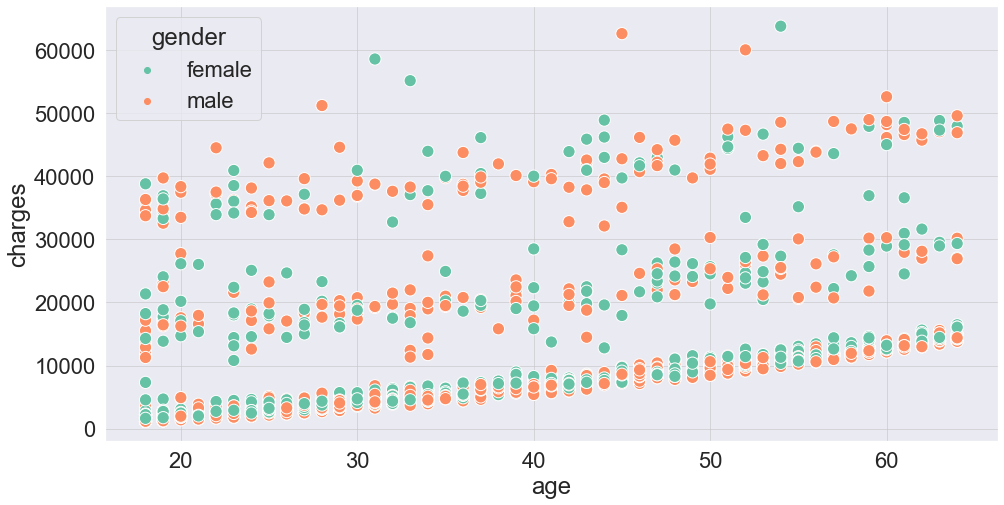

In [31]:
plt.figure(figsize=(16,8))

sns.scatterplot(x="age", y="charges", data=df, hue=df['gender'], palette="Set2", s=150)
plt.grid(b=True, which='major', color='silver', linewidth=0.5)
plt.grid(b=True, which='minor', color='silver', linewidth=0.5)
plt.show()

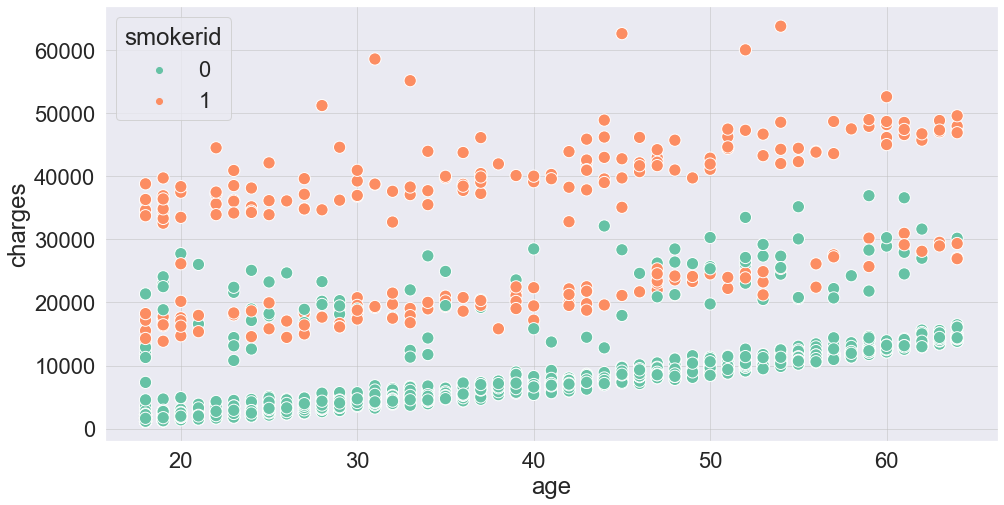

In [50]:
plt.figure(figsize=(16,8))

sns.scatterplot(x="age", y="charges", data=df, hue=df['smokerid'], palette="Set2", s=150)
plt.grid(b=True, which='major', color='silver', linewidth=0.5)
plt.grid(b=True, which='minor', color='silver', linewidth=0.5)
plt.show()

The demand curve will be the trendline between weekdays and weekend, which is represented by the red line above. The Equation of the demand curve is also available.

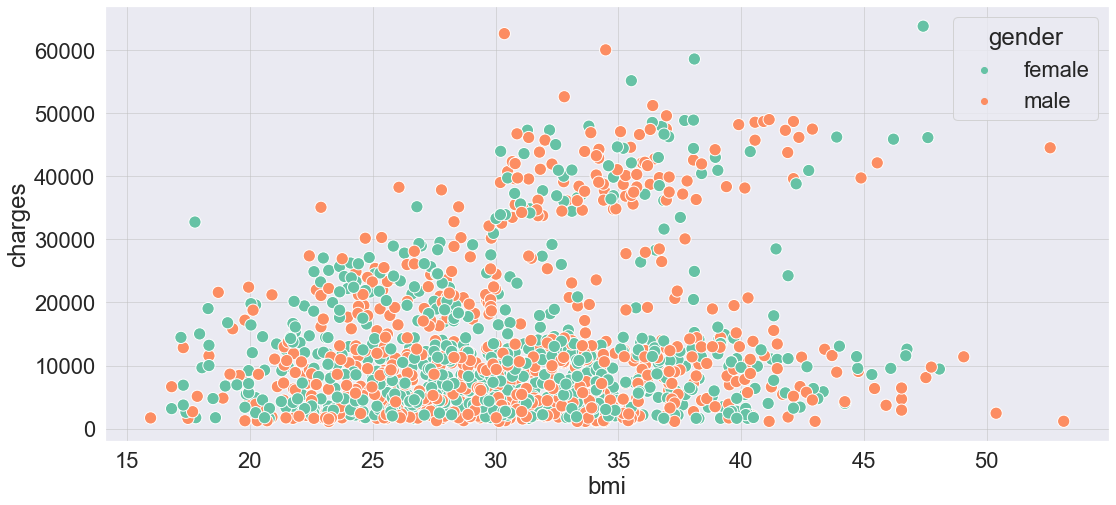

In [33]:
plt.figure(figsize=(18,8))

sns.scatterplot(x="bmi", y="charges", data=df, hue=df['gender'], palette="Set2", s=150)
plt.grid(b=True, which='major', color='silver', linewidth=0.5)
plt.grid(b=True, which='minor', color='silver', linewidth=0.5)
plt.show()

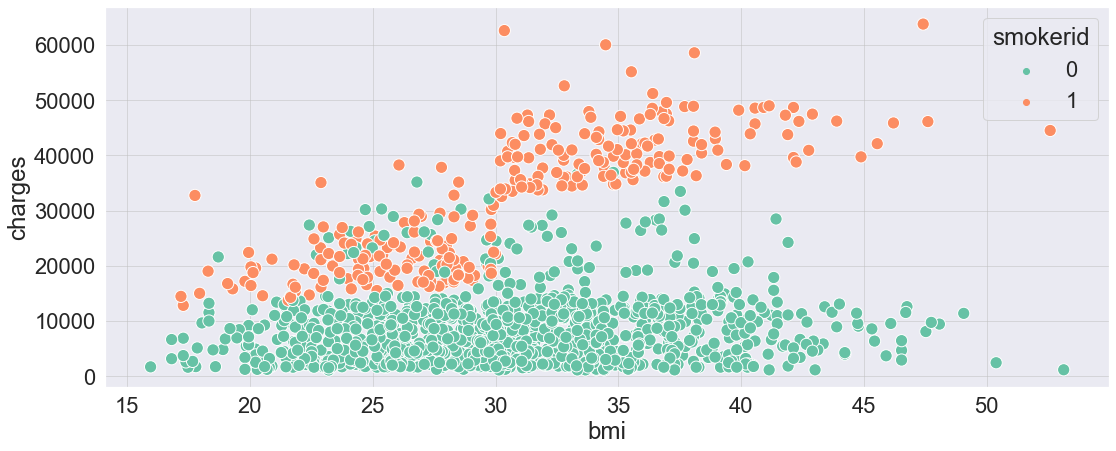

In [51]:
plt.figure(figsize=(18,7))

sns.scatterplot(x="bmi", y="charges", data=df, hue=df['smokerid'], palette="Set2", s=150)
plt.grid(b=True, which='major', color='silver', linewidth=0.5)
plt.grid(b=True, which='minor', color='silver', linewidth=0.5)
plt.show()

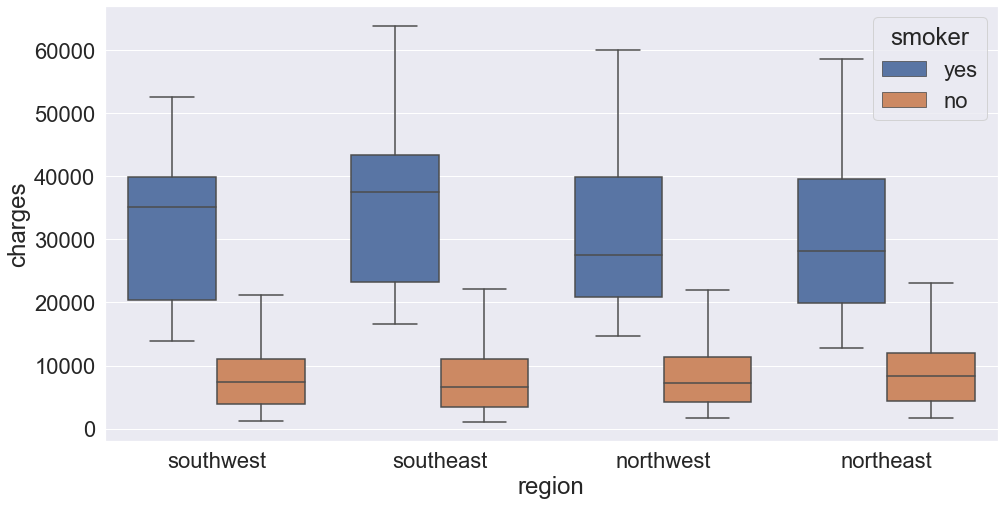

In [36]:
# lets see how working hours per week vary across different occupation
plt.figure(figsize=(16,8))
sns.boxplot(y="charges", x="region", data=df,hue='smoker',showfliers=False);

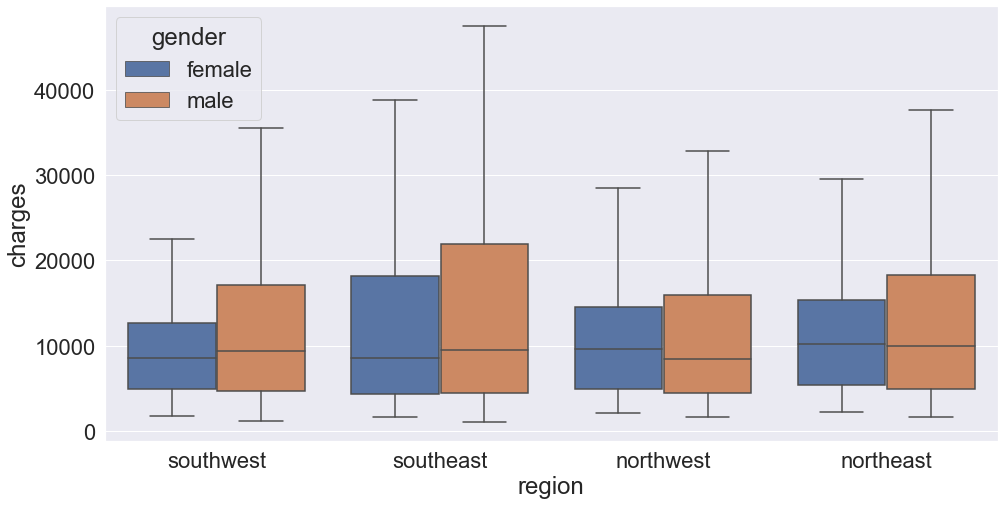

In [37]:
plt.figure(figsize=(16,8))
sns.boxplot(y="charges", x="region", data=df,hue='gender',showfliers=False);

# Linear Regression

In [38]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [39]:
#Drop all the columns with categorical variables
X = df.drop(['charges','gender','smoker','region'], axis=1)
# the dependent variable (the one where I want to check the relations)
y = df[['charges']]

In [40]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [41]:
#Fit a LINEAR Regression
regression_model = LinearRegression()
lr = regression_model.fit(X_train, y_train)

In [42]:
print('R^2 of training set is ',regression_model.score(X_train, y_train))

R^2 of training set is  0.754417539933139


In [43]:
print('R^2 of test set is',regression_model.score(X_test, y_test))

R^2 of test set is 0.73399749548324


In [44]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for age is 257.5033183107572
The coefficient for bmi is 387.23083530339056
The coefficient for children is 571.4110309789443
The coefficient for regionid is 345.9683314964565
The coefficient for genderid is 546.5882007846475
The coefficient for smokerid is 23385.197460903426


In [45]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -15749.511294686183


In [46]:
X_train.shape

(935, 6)

In [47]:
va = regression_model.coef_
coeff_data = pd.DataFrame()
coeff_data['Feature'] = X_train.columns
coeff_data['Coefs'] = regression_model.coef_[0]

coeff_data = coeff_data.append({'Feature': "Intercept", 'Coefs': regression_model.intercept_}, ignore_index = True)
coeff_data

,Feature,Coefs
0,age,257.503
1,bmi,387.231
2,children,571.411
3,regionid,345.968
4,genderid,546.588
5,smokerid,23385.2
6,Intercept,[-15749.511294686183]


In [48]:
#### Let us write the equation of the fit
Equation = "Charge ="
print(Equation, end='\t')
for i in range(0, 7):
    if(i!=6):
        print("(",coeff_data.iloc[i].Coefs,")", "*", coeff_data.iloc[i].Feature, "+", end = '  ')
    else:
        print(coeff_data.iloc[i].Coefs)

Charge =	( 257.5033183107572 ) * age +  ( 387.23083530339056 ) * bmi +  ( 571.4110309789443 ) * children +  ( 345.9683314964565 ) * regionid +  ( 546.5882007846475 ) * genderid +  ( 23385.197460903426 ) * smokerid +  [-15749.51129469]


In [49]:
import statsmodels.api as sm

# unlike sklearn, statsmodels does not add a constant to the data on its own
# we have to add the constant manually
X = sm.add_constant(X_train)

linearmodel = sm.OLS(y_train, X_train).fit()

print_model = linearmodel.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              1104.
Date:                Fri, 06 May 2022   Prob (F-statistic):                        0.00
Time:                        12:15:05   Log-Likelihood:                         -9525.9
No. Observations:                 935   AIC:                                  1.906e+04
Df Residuals:                     929   BIC:                                  1.909e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [52]:
import statsmodels.api as sm

# unlike sklearn, statsmodels does not add a constant to the data on its own
# we have to add the constant manually
X = sm.add_constant(X_test)

linearmodel = sm.OLS(y_test, X_test).fit()

print_model = linearmodel.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              462.8
Date:                Fri, 06 May 2022   Prob (F-statistic):                   1.77e-175
Time:                        15:23:35   Log-Likelihood:                         -4069.6
No. Observations:                 402   AIC:                                      8151.
Df Residuals:                     396   BIC:                                      8175.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------